## INSTALLATION ET IMPORTATION DES LIBRAIRIES NECESSAIRES

In [1]:
#Installation des librairies nécessaires
!pip install pandas fiona shapely pyproj rtree 
!pip install contextily
!pip install geopandas
!pip install topojson
!pip install --upgrade urllib3
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 74.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 71.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.2 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-6gq4s7n9
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-6gq4s7n9
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.7 MB/s eta 

In [82]:
#Importation des libraries nécessaires 
import requests
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from cartiflette import carti_download
import gzip
import io
from shapely.geometry import Point

In [3]:
#Importation des fonctions créées
from fonctions import recuperer_donnees
from fonctions import recuperer_donnees_gz
from fonctions import labeliser_variables

## I. IMPORTATION DES BASES DE DONNEES

Les données nécessaires pour notre travail sont les **données sur les accidents corporels de la circulation routière** dans chaque région de France métropolitaine hors Corse. Les bases de données qui seront utilisées répertorient l'intégralité des accidents corporels de la circulation, intervenus en 2023 en France métropolitaine, dans les départements d’Outre-mer  et dans les autres territoires d’outre-mer.

Quatre (04) bases principales ont donc été importées:
- Une base des usagers impliqués dans les accidents corporels de la circulation en 2023 en France;
- Une base des véhicules impliqués dans les accidents corporels de la circulation en 2023 en France;
- Une des lieux des accidents corporels de la circulation en 2023 en France;
- Une des caractéristiques des accidents corporels de la circulation en 2023 en France.

Les quatres bases ont été récupérées à partir de l'API de Data Gouv.

Par ailleurs, trois bases complémentaires ont été importées :  
- Une base de correspondance département région (pour faire des analyses par région, étant donné que nous n'avons que les départements dans les bases de données sur les accidents);
- Un géodataframe qui aidera pour les représentations cartographiques, obtenu à partir de cartiflette;
- Une base de données météorologiques pour l'année 2023 sur les départements d'Ile-de-France ( 75, 77, 78, 91, 92, 93, 94, 95 ) à partir de l'API de Data Gouv.

In [4]:
# Chargement du fichier des usagers

dataset_id = "68848e2a-28dd-4efc-9d5f-d512f7dbe66f"
fichier_csv = "usagers-2023.csv"

df_usagers = recuperer_donnees(dataset_id,fichier_csv,';')
df_usagers.head()

Le fichier a été téléchargé avec succès.


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202300000001,203 851 184,155 680 557,A01,1,1,4,1,1978.0,5,2,0,-1,-1,-1,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,1,2,1997.0,9,1,0,-1,-1,-1,-1
2,202300000002,203 851 183,155 680 556,A01,10,3,3,1,1997.0,9,0,-1,-1,2,3,1
3,202300000003,203 851 180,155 680 554,B01,1,1,3,1,1987.0,0,2,6,0,0,0,-1
4,202300000003,203 851 181,155 680 555,A01,1,1,1,2,1984.0,0,1,0,0,0,0,-1


In [5]:
# Chargement du fichier des véhicules

dataset_id = "146a42f5-19f0-4b3e-a887-5cd8fbef057b"
fichier_csv = "vehicules-2023.csv"

df_vehicules = recuperer_donnees(dataset_id,fichier_csv,';')
df_vehicules.head()

Le fichier a été téléchargé avec succès.


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202300000001,155 680 557,A01,1,30,0,0,5,1,1,NaN
1,202300000002,155 680 556,A01,2,7,0,1,1,1,1,NaN
2,202300000003,155 680 554,B01,1,2,0,2,1,16,1,NaN
3,202300000003,155 680 555,A01,2,7,0,2,2,15,1,NaN
4,202300000004,155 680 551,B01,1,7,0,2,9,2,4,NaN


In [48]:
#Chargement du fichier des lieux

dataset_id = "8bef19bf-a5e4-46b3-b5f9-a145da4686bc"
fichier_csv = "lieux-2023.csv"

df_lieux = recuperer_donnees(dataset_id,fichier_csv,';')
df_lieux.head()

Le fichier a été téléchargé avec succès.


/home/onyxia/work/Projet/fonctions.py:34: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier_csv, sep = sep)


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202300000001,4,RUE DE RIVOLI,0,NaN,1,2,0,1,-1,-1,1,NaN,-1,2,0,1,30
1,202300000001,4,RUE SAINT FLORENTIN,0,NaN,1,1,0,1,-1,-1,1,NaN,-1,2,0,1,30
2,202300000002,3,120,0,NaN,2,3,2,1,-1,-1,1,NaN,-1,2,0,1,50
3,202300000003,3,5,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50
4,202300000003,3,87,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50


In [7]:
#Chargement du fichier des caracteristiques

dataset_id = "104dbb32-704f-4e99-a71e-43563cb604f2"
fichier_csv = "caract-2023.csv"

df_caract = recuperer_donnees(dataset_id,fichier_csv,';')
df_caract.head()

Le fichier a été téléchargé avec succès.


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202300000001,7,5,2023,06:00,1,75,75101,2,4,2,7,RUE DE RIVOLI,"48,86638600","2,32347100"
1,202300000002,7,5,2023,05:30,5,94,94080,2,1,3,6,Avenue de Paris,"48,84547782","2,42868146"
2,202300000003,7,5,2023,20:50,1,94,94022,2,3,2,1,Avenue du Général Leclerc,"48,76240000","2,40655000"
3,202300000004,6,5,2023,23:57,5,94,94078,2,1,3,5,Rue de Paris,"48,73248432","2,44687575"
4,202300000005,7,5,2023,00:50,5,94,94068,2,2,3,3,56bis Avenue Raspail,"48,78581000","2,49217000"


In [41]:
#Chargement du fichier de correspondance region-departement

dataset_id = "987227fb-dcb2-429e-96af-8979f97c9c84"
fichier_csv = "departements-region.csv"

df_region_dep = recuperer_donnees(dataset_id,fichier_csv,',')
#df_region_dep = df_region_dep.rename(columns = {'num_dep' : 'dep'})
df_region_dep.head()

Le fichier a été téléchargé avec succès.


,num_dep,dep_name,region_name
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur


In [9]:
#Chargement du géodataframe

carte_reg = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

carte_dep = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

carte_reg.head(10)

,INSEE_REG,PAYS,LIBELLE_REGION,POPULATION,SOURCE,geometry
0,1,France,Guadeloupe,384239,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-61.62648 16.27275, -61.62658 ..."
1,3,France,Guyane,281678,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-51.6408 4.21282, -51.64144 4...."
2,2,France,Martinique,364508,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-60.93246 14.7306, -60.9326 14..."
3,6,France,Mayotte,256518,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((45.08357 -12.96139, 45.08547 -..."
4,84,France,Auvergne-Rhône-Alpes,8042936,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((6.06386 46.41639, 6.06267 46.4168, 6..."
5,76,France,Occitanie,5933185,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((2.06288 44.97662, 2.06244 44.9..."
6,53,France,Bretagne,3354854,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-3.97907 47.70396, -3.97953 47..."
7,75,France,Nouvelle-Aquitaine,6010289,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-0.31325 42.8494, -0.31227 42...."
8,28,France,Normandie,3325032,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-1.924 49.66512, -1.92439 49.6..."
9,93,France,Provence-Alpes-Côte d'Azur,5081101,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((4.23021 43.46049, 4.2329 43.46..."


In [10]:
#Chargement des données météorologiques
RRTVent_95 = recuperer_donnees_gz('00b37d57-76cf-4531-8fde-112a576a9a6e', 'QUOT_departement_95_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_95 = recuperer_donnees_gz('b3482517-0713-4eac-afcc-eb5b135a6ff2', 'QUOT_departement_95_periode_2023_2024_autres_parametres', ';')

RRTVent_94 = recuperer_donnees_gz('dc4b8ca5-e72b-4f24-82c6-9d75f08c594b', 'QUOT_departement_94_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_94 = recuperer_donnees_gz('4ff5e1a0-c949-47ce-bdbf-e625c6df3f0e', 'QUOT_departement_94_periode_2023_2024_autres_parametres', ';')

RRTVent_93 = recuperer_donnees_gz('8818da6a-3c3a-4c1e-ba7e-1e1a9c66120a', 'QUOT_departement_93_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_93 = recuperer_donnees_gz('6eadda53-ef58-4246-91ac-e84ed1a75e8f', 'QUOT_departement_93_periode_2023_2024_autres_parametres', ';')

RRTVent_92 = recuperer_donnees_gz('881525f4-f786-4eb6-ac4d-d62f3089ed19', 'QUOT_departement_92_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_92 = recuperer_donnees_gz('634cc1ec-7d2a-47e4-9ef1-be51a894dbba', 'QUOT_departement_92_periode_2023_2024_autres_parametres', ';')

RRTVent_91 = recuperer_donnees_gz('e3719036-f756-4a42-b1d8-ba65235d60e1', 'QUOT_departement_91_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_91 = recuperer_donnees_gz('0bce2def-d015-41e4-9d14-5127eed7b94d', 'QUOT_departement_91_periode_2023_2024_autres_parametres', ';')

RRTVent_78 = recuperer_donnees_gz('c5aabcc5-3f3d-4caa-ac8a-c766685cf7b5', 'QUOT_departement_78_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_78 = recuperer_donnees_gz('587bcad8-7514-45fa-a023-39ddd5215433', 'QUOT_departement_78_periode_2023_2024_autres_parametres', ';')

RRTVent_77 = recuperer_donnees_gz('473c287c-001a-4bfa-8c6c-f59afe61bead', 'QUOT_departement_77_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_77 = recuperer_donnees_gz('2b592ebd-d8c4-4fbd-8205-e04fab626ca8', 'QUOT_departement_77_periode_2023_2024_autres_parametres', ';')

RRTVent_75 = recuperer_donnees_gz('aba837dc-fc7c-4010-ab5e-0eb02feb0010', 'QUOT_departement_77_periode_2023_2024_RR-T-Vent', ';')
autres_parametres_75 = recuperer_donnees_gz('863521b9-9e04-4255-b720-6d3ff4da3ef1', 'QUOT_departement_77_periode_2023_2024_autres_parametres', ';')
RRTVent_75.tail()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,HTN,QHTN,TX,QTX,HTX,QHTX,TM,QTM,TNTXM,QTNTXM,TAMPLI,QTAMPLI,TNSOL,QTNSOL,TN50,QTN50,DG,QDG,FFM,QFFM,FF2M,QFF2M,FXY,QFXY,DXY,QDXY,HXY,QHXY,FXI,QFXI,DXI,QDXI,HXI,QHXI,FXI2,QFXI2,DXI2,QDXI2,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
4419,75119001,BUTTES CHAUMONT,48.876833,2.380833,97,20230127,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4420,75119001,BUTTES CHAUMONT,48.876833,2.380833,97,20230128,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4421,75119001,BUTTES CHAUMONT,48.876833,2.380833,97,20230129,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4422,75119001,BUTTES CHAUMONT,48.876833,2.380833,97,20230130,0.2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4423,75119001,BUTTES CHAUMONT,48.876833,2.380833,97,20230131,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## II. Traitement des données 

### II.1. Suppression des éventuels doublons

A priori, les bases de données ne contiennent aucun doublons. Mais, nous prenons les précautions pour ne pas avoir des soucis après les fusions des différentes bases

In [11]:
df_vehicules = df_vehicules.drop_duplicates()

df_region_dep = df_region_dep.drop_duplicates()

### II.1. Traitement de la base des usagers

Supression d'éventuels doublons (à priori, il n'y en a pas, mais nous prenons quand même les précautions)

In [12]:
df_usagers = df_usagers.drop_duplicates()

Supression des variables non pertinentes pour l'analyse

In [13]:
df_usagers = df_usagers.loc[:,['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'catu', 'grav', 'trajet', 'secu1', 'secu2', 'secu3']]

Nous renommons les variables de la base pour avoir des noms de variables plus intuitifs

In [14]:
noms_col = {'Num_Acc':'Num_Acc','id_usager':'id_usager','id_vehicule':'id_vehicule','num_veh':'num_veh','catu':'cat_usager',
'grav':'gravite','trajet':'motif','secu1':'equip_secu_1','secu2':'equip_secu_2','secu3':'equip_secu_3'}
df_usagers = df_usagers.rename(columns=noms_col)

Vérification de l'existence de valeurs manquantes 

In [15]:
df_usagers.isna().sum()

Num_Acc         0
id_usager       0
id_vehicule     0
num_veh         0
cat_usager      0
gravite         0
motif           0
equip_secu_1    0
equip_secu_2    0
equip_secu_3    0
dtype: int64

Vérification des types des variables 

In [16]:
print(df_usagers.dtypes)

Num_Acc          int64
id_usager       object
id_vehicule     object
num_veh         object
cat_usager       int64
gravite          int64
motif            int64
equip_secu_1     int64
equip_secu_2     int64
equip_secu_3     int64
dtype: object


In [17]:
df_usagers.head()

,Num_Acc,id_usager,id_vehicule,num_veh,cat_usager,gravite,motif,equip_secu_1,equip_secu_2,equip_secu_3
0,202300000001,203 851 184,155 680 557,A01,1,4,5,2,0,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,9,1,0,-1
2,202300000002,203 851 183,155 680 556,A01,3,3,9,0,-1,-1
3,202300000003,203 851 180,155 680 554,B01,1,3,0,2,6,0
4,202300000003,203 851 181,155 680 555,A01,1,1,0,1,0,0


Transformation des types des variables

In [18]:
#On enlève les espaces qui servent de séparateur de décimal et on transforme en entier
df_usagers['id_usager']=df_usagers['id_usager'].str.replace('\xa0', '').astype(int)
df_usagers['id_vehicule']=df_usagers['id_vehicule'].str.replace('\xa0', '').astype(int)

In [19]:
#On transforme en chaîne de caractères
df_usagers['num_veh']=df_usagers['num_veh'].astype(str)

In [57]:
#On labellise les variables catégorielles
usagers_labels = { 'cat_usager': {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}, 
                'gravite': {1: 'Indemne', 2: 'Tué', 3: 'Blessé hospitalisé', 4: 'Blessé léger'},
                'motif': {-1: 'Non renseigné', 0: 'Non renseigné', 1: 'Domicile – travail',2: 'Domicile – école', 3: 'Courses – achats', 4: 'Utilisation professionnelle', 5: 'Promenade – loisirs', 9: 'Autre'},
                'equip_secu_1': {-1: 'Non renseigné', 0: 'Aucun équipement', 1: 'Ceinture', 2: 'Casque', 3: 'Dispositif enfants', 4: 'Gilet réfléchissant', 5: 'Airbag (2RM/3RM)', 6: 'Gants (2RM/3RM)', 7: 'Gants + Airbag (2RM/3RM)', 8: 'Non déterminable', 9:'Autre'},
                'equip_secu_2': {-1: 'Non renseigné', 0: 'Aucun équipement', 1: 'Ceinture', 2: 'Casque', 3: 'Dispositif enfants', 4: 'Gilet réfléchissant', 5: 'Airbag (2RM/3RM)', 6: 'Gants (2RM/3RM)', 7: 'Gants + Airbag (2RM/3RM)', 8: 'Non déterminable', 9:'Autre'},
                'equip_secu_3': {-1: 'Non renseigné', 0: 'Aucun équipement', 1: 'Ceinture', 2: 'Casque', 3: 'Dispositif enfants', 4: 'Gilet réfléchissant', 5: 'Airbag (2RM/3RM)', 6: 'Gants (2RM/3RM)', 7: 'Gants + Airbag (2RM/3RM)', 8: 'Non déterminable', 9:'Autre'} }

df_usagers = labeliser_variables(df_usagers,usagers_labels)
df_usagers.head()

,Num_Acc,id_usager,id_vehicule,num_veh,cat_usager,gravite,motif,equip_secu_1,equip_secu_2,equip_secu_3
0,202300000001,203851184,155680557,A01,Conducteur,Blessé léger,Promenade – loisirs,Casque,Aucun équipement,Non renseigné
1,202300000002,203851182,155680556,A01,Conducteur,Indemne,Autre,Ceinture,Aucun équipement,Non renseigné
2,202300000002,203851183,155680556,A01,Piéton,Blessé hospitalisé,Autre,Aucun équipement,Non renseigné,Non renseigné
3,202300000003,203851180,155680554,B01,Conducteur,Blessé hospitalisé,Non renseigné,Casque,Gants (2RM/3RM),Aucun équipement
4,202300000003,203851181,155680555,A01,Conducteur,Indemne,Non renseigné,Ceinture,Aucun équipement,Aucun équipement


### II.2. Traitement de la base des véhicules

Suppression des éventuels doublons

In [21]:
df_vehicules = df_vehicules.drop_duplicates()

Suppression des variables non pertinentes pour l'analyse

In [22]:
df_vehicules = df_vehicules.loc[:,['Num_Acc', 'id_vehicule', 'num_veh', 'catv', 'motor']]

On renomme les variables de la base

In [23]:
noms_col = {'Num_Acc':'Num_Acc','id_vehicule':'id_vehicule','num_veh':'num_veh','catv':'cat_vehicule',
'motor':'moteur_vehicule'}
df_vehicules = df_vehicules.rename(columns=noms_col)

Vérification de l'existence de valeurs manquantes

In [24]:
df_vehicules.isna().sum()

Num_Acc            0
id_vehicule        0
num_veh            0
cat_vehicule       0
moteur_vehicule    0
dtype: int64

Vérification des types des variables

In [25]:
df_vehicules.dtypes

Num_Acc             int64
id_vehicule        object
num_veh            object
cat_vehicule        int64
moteur_vehicule     int64
dtype: object

In [26]:
#On supprime l'espace et on transforme en entier
df_vehicules['id_vehicule']=df_vehicules['id_vehicule'].str.replace('\xa0', '').astype(int)

In [27]:
df_vehicules.head()

,Num_Acc,id_vehicule,num_veh,cat_vehicule,moteur_vehicule
0,202300000001,155680557,A01,30,1
1,202300000002,155680556,A01,7,1
2,202300000003,155680554,B01,2,1
3,202300000003,155680555,A01,7,1
4,202300000004,155680551,B01,7,4


In [58]:
#On labellise les deux dernières variables
vehicule_labels = {'cat_vehicule': {0: 'Indéterminable', 1: 'Bicyclette', 2: 'Cyclomoteur <50cm3', 3: 'Voiturette (Quadricycle à moteur carrossé)', 4: 'Référence inutilisée depuis 2006 (scooter immatriculé)', 5: 'Référence inutilisée depuis 2006 (motocyclette)', 6: 'Référence inutilisée depuis 2006 (side-car)', 7: 'VL seul', 8: 'Référence inutilisée depuis 2006 (VL + caravane)', 9: 'Référence inutilisée depuis 2006 (VL + remorque)', 10: 'VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque', 11: 'Référence inutilisée depuis 2006 (VU (10) + caravane)', 12: 'Référence inutilisée depuis 2006 (VU (10) + remorque)', 13: 'PL seul 3,5T <PTCA <= 7,5T', 14: 'PL seul > 7,5T', 15: 'PL > 3,5T + remorque', 16: 'Tracteur routier seul', 17: 'Tracteur routier + semi-remorque', 18: 'Référence inutilisée depuis 2006 (transport en commun)', 19: 'Référence inutilisée depuis 2006 (tramway)', 20: 'Engin spécial', 21: 'Tracteur agricole', 30: 'Scooter < 50 cm3', 31: 'Motocyclette > 50 cm3 et <= 125 cm3', 32: 'Scooter > 50 cm3 et <= 125 cm3', 33: 'Motocyclette > 125 cm3', 34: 'Scooter > 125 cm3', 35: 'Quad léger <= 50 cm3 (Quadricycle à moteur non carrossé)', 36: 'Quad lourd > 50 cm3 (Quadricycle à moteur non carrossé)', 37: 'Autobus', 38: 'Autocar', 39: 'Train', 40: 'Tramway', 41: '3RM <= 50 cm3', 42: '3RM > 50 cm3 <= 125 cm3', 43: '3RM > 125 cm3', 50: 'EDP à moteur', 60: 'EDP sans moteur', 80: 'VAE', 99: 'Autre véhicule'},
                    'moteur_vehicule':{-1: 'Non renseigné', 0: 'Inconnue', 1: 'Hydrocarbures', 2: 'Hybride électrique', 3: 'Electrique', 4: 'Hydrogène', 5: 'Humaine', 6: 'Autre'}}

df_vehicules = labeliser_variables(df_vehicules,vehicule_labels)

### II.3. Traitement de la base des lieux

Supression d'éventuels doublons

In [49]:
df_lieux = df_lieux.drop_duplicates()

Supression des variables non pertinentes pour l'analyse

In [50]:
df_lieux = df_lieux.loc[:,['Num_Acc', 'catr', 'voie', 'surf', 'vma']]

Nous renommons les variables

In [51]:
noms_col = {'Num_Acc':'Num_Acc','catr':'cat_route','voie':'num_route','surf':'etat_surface',
'vma':'vma'}
df_lieux = df_lieux.rename(columns=noms_col)

Verification de l'existence des valeurs manquantes

In [52]:
df_lieux.isna().sum()

Num_Acc             0
cat_route           0
num_route       12747
etat_surface        0
vma                 0
dtype: int64

Le numero de route a trop de valeurs manquantes. Et comme elle n'est pas essentielle aux analyses, il vaut mieux l'enlever

In [53]:
df_lieux = df_lieux.loc[:,['Num_Acc', 'cat_route', 'etat_surface', 'vma']]

Vérification des types des variables

In [54]:
df_lieux.dtypes

Num_Acc         int64
cat_route       int64
etat_surface    int64
vma             int64
dtype: object

Nous labellisons les variables catégorielles

In [55]:
lieux_labels = {'cat_route': {1: 'Autoroute', 2: 'Route nationale', 3: 'Route Départementale', 4: 'Voie Communales', 5: 'Hors réseau public', 6: 'Parc de stationnement ouvert à la circulation publique', 7: 'Routes de métropole urbaine', 9: 'Autre'},
                'etat_surface':{-1: 'Non renseigné', 1: 'Normale', 2: 'Mouillée', 3: 'Flaques', 4: 'Inondée', 5: 'Enneigée', 6: 'Boue', 7: 'Verglacée', 8: 'Corps gras – huile', 9: 'Autre'}}

df_lieux = labeliser_variables(df_lieux,lieux_labels)

In [56]:
df_lieux.head()

,Num_Acc,cat_route,etat_surface,vma
0,202300000001,Voie Communales,Mouillée,30
1,202300000001,Voie Communales,Mouillée,30
2,202300000002,Route Départementale,Mouillée,50
3,202300000003,Route Départementale,Mouillée,50
4,202300000003,Route Départementale,Mouillée,50


### II.4. Traitement de la base des caractéristiques

Suppression des doublons

In [59]:
df_caract = df_caract.drop_duplicates()

Supression des variables non pertinentes pour l'analyse

In [60]:
df_caract = df_caract.loc[:, ['Num_Acc', 'jour', 'mois', 'lum', 'dep', 'com', 'agg', 'atm', 'lat', 'long']]

On renomme les variables

In [61]:
noms_col = {'Num_Acc':'Num_Acc', 'jour':'jour', 'mois':'mois', 'lum':'eclairage', 'dep':'INSEE_DEP', 'com':'Commune', 'agg':'agglom', 'atm':'atm', 'lat':'lat', 'long':'long'}
df_caract = df_caract.rename(columns=noms_col)

Existence de valeurs manquantes

In [63]:
df_caract.isna().sum()

Num_Acc      0
jour         0
mois         0
eclairage    0
INSEE_DEP    0
Commune      0
agglom       0
atm          0
lat          0
long         0
dtype: int64

Pour éviter les problèmes de types, nous allons donner d'autres valeurs aux départements de la corse

In [76]:
df_caract.loc[df_caract['INSEE_DEP'] == '2A', 'INSEE_DEP'] = '999'
df_caract.loc[df_caract['INSEE_DEP'] == '2B', 'INSEE_DEP'] = '998'
df_caract['INSEE_DEP'] = df_caract['INSEE_DEP'].astype(int)

/tmp/ipykernel_7257/2420801488.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_caract.loc[df_caract['INSEE_DEP'] == '2A', 'INSEE_DEP'] = '999'


Vérification des types

In [70]:
df_caract.dtypes

Num_Acc        int64
jour           int64
mois          object
eclairage     object
INSEE_DEP      int64
Commune       object
agglom        object
atm           object
lat          float64
long         float64
dtype: object

Transformation des coordonnées en float

In [68]:
df_caract['lat']=df_caract['lat'].str.replace(',', '.').astype(float)
df_caract['long']=df_caract['long'].str.replace(',', '.').astype(float)

Labelisation des variables catégorielles

In [65]:
caract_labels = {'eclairage':{1: 'Plein jour', 2: 'Crépuscule ou aube', 3: 'Nuit sans éclairage public', 4: 'Nuit avec éclairage public non allumé', 5: 'Nuit avec éclairage public allumé'},
                'agglom':{1:'Hors agglomeration', 2: 'En agglomeration'},
                'mois': {1: 'Janvier', 2: 'Février', 3: 'Mars', 4: 'Avril', 5: 'Mai', 6: 'Juin', 7: 'Juillet', 8: 'Août', 9: 'Septembre', 10: 'Octobre', 11: 'Novembre', 12: 'Décembre'},
                'atm': {-1: 'Non renseigné', 1: 'Normale', 2: 'Pluie légère', 3: 'Pluie forte', 4: 'Neige - grêle', 5: 'Brouillard - fumée', 6: 'Vent fort - tempête', 7: 'Temps éblouissant', 8: 'Temps couvert', 9: 'Autre'},}

df_caract = labeliser_variables(df_caract,caract_labels)

### II.5. Traitement de la base de correspondance départements-regions

Nous renommons le code des départements

In [72]:
df_region_dep = df_region_dep.rename(columns={'num_dep': 'INSEE_DEP'})

Nous créons ensuite une colonne des codes des régions 

In [74]:
regions_insee = {
    'Guadeloupe': '01',
    'Martinique': '02',
    'Guyane': '03',
    'La Réunion': '04',
    'Mayotte': '06',
    'Île-de-France': '11',
    'Centre-Val de Loire': '24',
    'Bourgogne-Franche-Comté': '27',
    'Normandie': '28',
    'Hauts-de-France': '32',
    'Grand Est': '44',
    'Pays de la Loire': '52',
    'Bretagne': '53',
    'Nouvelle-Aquitaine': '75',
    'Occitanie': '76',
    'Auvergne-Rhône-Alpes': '84',
    'Provence-Alpes-Côte d\'Azur': '93',
    'Corse': '94'
}

df_region_dep['INSEE_REG'] = df_region_dep['region_name'].map(regions_insee)

In [77]:
df_region_dep.dtypes

INSEE_DEP      object
dep_name       object
region_name    object
INSEE_REG      object
dtype: object

In [78]:
df_region_dep.loc[df_region_dep['INSEE_DEP'] == '2A', 'INSEE_DEP'] = '999'
df_region_dep.loc[df_region_dep['INSEE_DEP'] == '2B', 'INSEE_DEP'] = '998'
df_region_dep['INSEE_DEP'] = df_region_dep['INSEE_DEP'].astype(int)
df_region_dep['INSEE_REG'] = df_region_dep['INSEE_REG'].astype(int)

#### Une fois ces traitements terminés, nous fusionnons les différentes bases de données en une seule qui constituera notre base de donnée de travail

In [79]:
df = pd.merge(df_usagers, df_vehicules, on = ['Num_Acc', 'id_vehicule', 'num_veh'], how = 'inner')
df = pd.merge(df, df_lieux, on = "Num_Acc", how = 'inner')
df = pd.merge(df, df_caract, on = "Num_Acc", how = 'inner')
df = pd.merge(df, df_region_dep, on='INSEE_DEP', how='inner')

df.head()

,Num_Acc,id_usager,id_vehicule,num_veh,cat_usager,gravite,motif,equip_secu_1,equip_secu_2,equip_secu_3,cat_vehicule,moteur_vehicule,cat_route,etat_surface,vma,jour,mois,eclairage,INSEE_DEP,Commune,agglom,atm,lat,long,dep_name,region_name,INSEE_REG
0,202300000001,203851184,155680557,A01,Conducteur,Blessé léger,Promenade – loisirs,Casque,Aucun équipement,Non renseigné,Scooter < 50 cm3,Hydrocarbures,Voie Communales,Mouillée,30,7,Mai,Plein jour,75,75101,En agglomeration,Pluie légère,48.866386,2.323471,Paris,Île-de-France,11
1,202300000001,203851184,155680557,A01,Conducteur,Blessé léger,Promenade – loisirs,Casque,Aucun équipement,Non renseigné,Scooter < 50 cm3,Hydrocarbures,Voie Communales,Mouillée,30,7,Mai,Plein jour,75,75101,En agglomeration,Pluie légère,48.866386,2.323471,Paris,Île-de-France,11
2,202300000002,203851182,155680556,A01,Conducteur,Indemne,Autre,Ceinture,Aucun équipement,Non renseigné,VL seul,Hydrocarbures,Route Départementale,Mouillée,50,7,Mai,Nuit avec éclairage public allumé,94,94080,En agglomeration,Pluie forte,48.845478,2.428681,Val-de-Marne,Île-de-France,11
3,202300000002,203851183,155680556,A01,Piéton,Blessé hospitalisé,Autre,Aucun équipement,Non renseigné,Non renseigné,VL seul,Hydrocarbures,Route Départementale,Mouillée,50,7,Mai,Nuit avec éclairage public allumé,94,94080,En agglomeration,Pluie forte,48.845478,2.428681,Val-de-Marne,Île-de-France,11
4,202300000003,203851180,155680554,B01,Conducteur,Blessé hospitalisé,Non renseigné,Casque,Gants (2RM/3RM),Aucun équipement,Cyclomoteur <50cm3,Hydrocarbures,Route Départementale,Mouillée,50,7,Mai,Plein jour,94,94022,En agglomeration,Pluie légère,48.762400,2.406550,Val-de-Marne,Île-de-France,11


In [81]:
df.describe()
#On a un total de 162266 enregistrements dans notre base de données

,Num_Acc,id_usager,id_vehicule,vma,jour,INSEE_DEP,lat,long,INSEE_REG
count,1.622660e+05,1.622660e+05,1.622660e+05,162266.000000,162266.000000,162266.000000,162266.000000,162266.000000,162266.000000
mean,2.023000e+11,2.037860e+08,1.556319e+08,54.782906,15.409642,111.391610,44.930957,1.702476,43.346160
std,1.582060e+04,3.761460e+04,2.806801e+04,26.854519,8.727104,215.621304,10.838676,12.754975,31.529873
min,2.023000e+11,2.037207e+08,1.555833e+08,-1.000000,1.000000,1.000000,-21.381762,-61.806011,1.000000
25%,2.023000e+11,2.037536e+08,1.556076e+08,50.000000,8.000000,35.000000,44.934531,1.269710,11.000000
50%,2.023000e+11,2.037861e+08,1.556318e+08,50.000000,15.000000,69.000000,47.993167,2.384566,32.000000
75%,2.023000e+11,2.038186e+08,1.556563e+08,70.000000,23.000000,85.000000,48.865850,4.681903,76.000000
max,2.023001e+11,2.038512e+08,1.556806e+08,130.000000,31.000000,999.000000,51.047490,55.820997,94.000000


### II.6. Traitement du géodataframe

Pour une meilleure visualisation, nous n'allons faire la représentation que pour la France métropolitaine.

Pour cela, nous gardons des fichiers géographiques, uniquement les régions et départements de la France métropolitaine

In [34]:
carte_reg = carte_reg.loc[carte_reg["INSEE_REG"] > 10]
carte_reg = carte_reg.loc[carte_reg["INSEE_REG"] != 94]

In [37]:
carte_dep.loc[carte_dep['INSEE_DEP'] == '2A', 'INSEE_DEP'] = 999
carte_dep.loc[carte_dep['INSEE_DEP'] == '2B', 'INSEE_DEP'] = 998

In [38]:
print(carte_dep.dtypes)
carte_dep['INSEE_DEP'] = carte_dep['INSEE_DEP'].astype(float).astype(int)
carte_dep = carte_dep.loc[carte_dep["INSEE_DEP"] < 971]
carte_dep = carte_dep.to_crs(2154)
carte_dep.head(2)

INSEE_DEP                object
PAYS                     object
LIBELLE_DEPARTEMENT      object
POPULATION                int32
SOURCE                   object
geometry               geometry
dtype: object


,INSEE_DEP,PAYS,LIBELLE_DEPARTEMENT,POPULATION,SOURCE,geometry
4,43,France,Haute-Loire,227570,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((770266.6 6473465.6, 770225.3 6473390..."
5,65,France,Hautes-Pyrénées,229567,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6..."


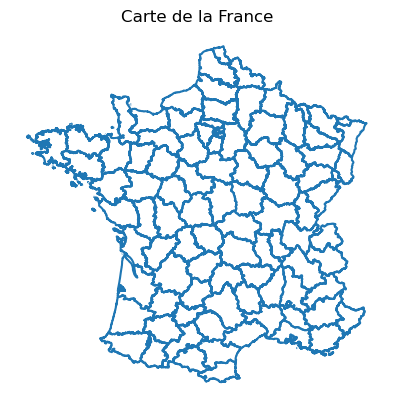

In [40]:
carte = carte_dep.boundary.plot()

# Change le crs:
#df = df.to_crs(epsg=2154)


#df.plot(ax=base, color='red')
carte.set_title('Carte de la France')
carte.set_axis_off()

### II.7. Traitement des données météorologiques

On ne garde que les données de 2023 (celles dont AAAAMMJJ commence par 2023)
On ne garde que les colonnes qui nous intéressent : 
- dans autres paramètres : AAAAMMJJ, INST ( durée d'insolation quotidiennen en mn ), GLOT ( rayonnement global quotidien, en J/cm2 ), DIRT ( rayonnement direct quotidien, en J/cm2 ), NEIGETOT06 ( épaisseur totale de neige mesurée ), NEIG ( occurrence de neige (0 s'il n'a pas neigé, 1 s'il a neigé) ), BROU (occurrence de brouillard), ORAG (occurrence d'orage), GRELE (occurrence de grêle), VERGLAS (occurrence de verglas), SOLNEIGE (occurrence de sol couvert de neige), FUMEE (occurrence de fumée), BRUME (occurrence de brume)
- dans RR-T-Vent : AAAAMMJJ, RR ( quantité de précipitation tombée en 24h, en mm ), FFM ( moyenne quotidienne de la force du vent, en m/s )

In [34]:
autres_parametres_75['AAAAMMJJ'] = autres_parametres_75['AAAAMMJJ'].astype(str)
RRTVent_75['AAAAMMJJ'] = RRTVent_75['AAAAMMJJ'].astype(str)
autres_parametres_75 = autres_parametres_75.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_75 = RRTVent_75.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_75 = autres_parametres_75.loc[autres_parametres_75['AAAAMMJJ'].str.startswith('2023')]
RRTVent_75 = RRTVent_75.loc[RRTVent_75['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_77['AAAAMMJJ'] = autres_parametres_77['AAAAMMJJ'].astype(str)
RRTVent_77['AAAAMMJJ'] = RRTVent_77['AAAAMMJJ'].astype(str)
autres_parametres_77 = autres_parametres_77.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_77 = RRTVent_77.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_77 = autres_parametres_77.loc[autres_parametres_77['AAAAMMJJ'].str.startswith('2023')]
RRTVent_77 = RRTVent_77.loc[RRTVent_77['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_78['AAAAMMJJ'] = autres_parametres_78['AAAAMMJJ'].astype(str)
RRTVent_78['AAAAMMJJ'] = RRTVent_78['AAAAMMJJ'].astype(str)
autres_parametres_78 = autres_parametres_78.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_78 = RRTVent_78.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_78 = autres_parametres_78.loc[autres_parametres_78['AAAAMMJJ'].str.startswith('2023')]
RRTVent_78 = RRTVent_78.loc[RRTVent_78['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_91['AAAAMMJJ'] = autres_parametres_91['AAAAMMJJ'].astype(str)
RRTVent_91['AAAAMMJJ'] = RRTVent_91['AAAAMMJJ'].astype(str)
autres_parametres_91 = autres_parametres_91.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_91 = RRTVent_91.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_91 = autres_parametres_91.loc[autres_parametres_91['AAAAMMJJ'].str.startswith('2023')]
RRTVent_91 = RRTVent_91.loc[RRTVent_91['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_92['AAAAMMJJ'] = autres_parametres_92['AAAAMMJJ'].astype(str)
RRTVent_92['AAAAMMJJ'] = RRTVent_92['AAAAMMJJ'].astype(str)
autres_parametres_92 = autres_parametres_92.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_92 = RRTVent_92.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_92 = autres_parametres_92.loc[autres_parametres_92['AAAAMMJJ'].str.startswith('2023')]
RRTVent_92 = RRTVent_92.loc[RRTVent_92['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_93['AAAAMMJJ'] = autres_parametres_93['AAAAMMJJ'].astype(str)
RRTVent_93['AAAAMMJJ'] = RRTVent_93['AAAAMMJJ'].astype(str)
autres_parametres_93 = autres_parametres_93.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_93 = RRTVent_93.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_93 = autres_parametres_93.loc[autres_parametres_93['AAAAMMJJ'].str.startswith('2023')]
RRTVent_93 = RRTVent_93.loc[RRTVent_93['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_94['AAAAMMJJ'] = autres_parametres_94['AAAAMMJJ'].astype(str)
RRTVent_94['AAAAMMJJ'] = RRTVent_94['AAAAMMJJ'].astype(str)
autres_parametres_94 = autres_parametres_94.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_94 = RRTVent_94.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_94 = autres_parametres_94.loc[autres_parametres_94['AAAAMMJJ'].str.startswith('2023')]
RRTVent_94 = RRTVent_94.loc[RRTVent_94['AAAAMMJJ'].str.startswith('2023')]

autres_parametres_95['AAAAMMJJ'] = autres_parametres_95['AAAAMMJJ'].astype(str)
RRTVent_95['AAAAMMJJ'] = RRTVent_95['AAAAMMJJ'].astype(str)
autres_parametres_95 = autres_parametres_95.loc[:,['AAAAMMJJ', 'GLOT', 'DIRT', 'INST', 'NEIG', 'BROU', 'ORAG', 'GRELE', 'VERGLAS', 'SOLNEIGE', 'FUMEE', 'BRUME']]
RRTVent_95 = RRTVent_95.loc[:,['AAAAMMJJ', 'RR', 'FFM']]
autres_parametres_95 = autres_parametres_95.loc[autres_parametres_95['AAAAMMJJ'].str.startswith('2023')]
RRTVent_95 = RRTVent_95.loc[RRTVent_95['AAAAMMJJ'].str.startswith('2023')]
autres_parametres_95.head()

,AAAAMMJJ,GLOT,DIRT,INST,NEIG,BROU,ORAG,GRELE,VERGLAS,SOLNEIGE,FUMEE,BRUME
0,20230101,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
1,20230102,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
2,20230103,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,1.0
3,20230104,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
4,20230105,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0


Comme il y a plusieurs postes de mesures dans chaque département, il y a plusieurs mesures différentes pour chaque date. On prend donc la moyenne de ces mesures.

In [35]:
RRTVent_75 = RRTVent_75.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_75 = autres_parametres_75.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_77 = RRTVent_77.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_77 = autres_parametres_77.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_78 = RRTVent_78.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_78 = autres_parametres_78.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_91 = RRTVent_91.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_91 = autres_parametres_91.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_92 = RRTVent_92.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_92 = autres_parametres_92.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_93 = RRTVent_93.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_93 = autres_parametres_93.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_94 = RRTVent_94.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_94 = autres_parametres_94.groupby('AAAAMMJJ', as_index=False).mean()

RRTVent_95 = RRTVent_95.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_95 = autres_parametres_95.groupby('AAAAMMJJ', as_index=False).mean()
autres_parametres_95


,AAAAMMJJ,GLOT,DIRT,INST,NEIG,BROU,ORAG,GRELE,VERGLAS,SOLNEIGE,FUMEE,BRUME
0,20230101,48.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,20230102,166.0,NaN,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
2,20230103,204.0,NaN,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
3,20230104,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,20230105,151.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
360,20231227,306.0,NaN,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
361,20231228,204.0,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
362,20231229,189.0,NaN,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
363,20231230,152.0,NaN,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Puis on fusionne les RRTVent et autres_parametres :

In [36]:
df_meteo_75 = pd.merge(autres_parametres_75, RRTVent_75, how = 'inner', on = 'AAAAMMJJ')
df_meteo_77 = pd.merge(autres_parametres_77, RRTVent_77, how = 'inner', on = 'AAAAMMJJ')
df_meteo_78 = pd.merge(autres_parametres_78, RRTVent_78, how = 'inner', on = 'AAAAMMJJ')
df_meteo_91 = pd.merge(autres_parametres_91, RRTVent_91, how = 'inner', on = 'AAAAMMJJ')
df_meteo_92 = pd.merge(autres_parametres_92, RRTVent_92, how = 'inner', on = 'AAAAMMJJ')
df_meteo_93 = pd.merge(autres_parametres_93, RRTVent_93, how = 'inner', on = 'AAAAMMJJ')
df_meteo_94 = pd.merge(autres_parametres_94, RRTVent_94, how = 'inner', on = 'AAAAMMJJ')
df_meteo_95 = pd.merge(autres_parametres_95, RRTVent_95, how = 'inner', on = 'AAAAMMJJ')
df_meteo_95

,AAAAMMJJ,GLOT,DIRT,INST,NEIG,BROU,ORAG,GRELE,VERGLAS,SOLNEIGE,FUMEE,BRUME,RR,FFM
0,20230101,48.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.333333,5.975
1,20230102,166.0,NaN,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,1.433333,3.950
2,20230103,204.0,NaN,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,3.266667,5.600
3,20230104,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.333333,7.500
4,20230105,151.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.466667,4.275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,20231227,306.0,NaN,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.266667,5.775
361,20231228,204.0,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,6.525
362,20231229,189.0,NaN,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.300000,6.575
363,20231230,152.0,NaN,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.733333,5.625


## ANALYSES CARTOGRAPHIQUES

Nous voulons représenter les accidents sur une carte. Pour cela, nous allons utiliser la base des caractéristiques qui contient les accidents et les coordonnées auxquelles elles sont survenues

In [97]:
# Nous nous limitons aux accidents de la France métropolitaine
df_caract_FM = df_caract.loc[df_caract["INSEE_DEP"] < 971]
df_caract_FM = pd.merge(df_caract_FM,df_region_dep, on = 'INSEE_DEP', how='inner')


In [98]:
geometry = [Point(xy) for xy in zip(df_caract_FM['long'], df_caract_FM['lat'])] 
points_acc = gpd.GeoDataFrame(df_caract_FM, geometry=geometry, crs="EPSG:2154")
points_acc.head()

,Num_Acc,jour,mois,eclairage,INSEE_DEP,Commune,agglom,atm,lat,long,dep_name,region_name,INSEE_REG,geometry
0,202300000001,7,Mai,Plein jour,75,75101,En agglomeration,Pluie légère,48.866386,2.323471,Paris,Île-de-France,11,POINT (2.323 48.866)
1,202300000002,7,Mai,Nuit avec éclairage public allumé,94,94080,En agglomeration,Pluie forte,48.845478,2.428681,Val-de-Marne,Île-de-France,11,POINT (2.429 48.845)
2,202300000003,7,Mai,Plein jour,94,94022,En agglomeration,Pluie légère,48.762400,2.406550,Val-de-Marne,Île-de-France,11,POINT (2.407 48.762)
3,202300000004,6,Mai,Nuit avec éclairage public allumé,94,94078,En agglomeration,Pluie forte,48.732484,2.446876,Val-de-Marne,Île-de-France,11,POINT (2.447 48.732)
4,202300000005,7,Mai,Nuit avec éclairage public allumé,94,94068,En agglomeration,Pluie forte,48.785810,2.492170,Val-de-Marne,Île-de-France,11,POINT (2.492 48.786)


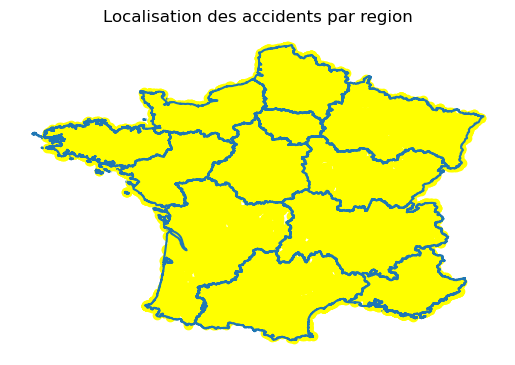

In [94]:
base = carte_reg.boundary.plot()

# # Change le crs:
points_acc = points_acc.to_crs(epsg=2154)


points_acc.plot(ax=base, color='yellow')
base.set_title('Localisation des accidents par region')
base.set_axis_off()

Cette carte ne nous permet pas de bien observer le phénomène des accidents

/tmp/ipykernel_7257/3103260899.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions_accidents['centroid'] = regions_accidents.geometry.centroid
/tmp/ipykernel_7257/3103260899.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions_accidents.centroid.x, regions_accidents.centroid.y, regions_accidents['LIBELLE_REGION']): plt.text(x, y, label, fontsize=8, ha='center', color='black')


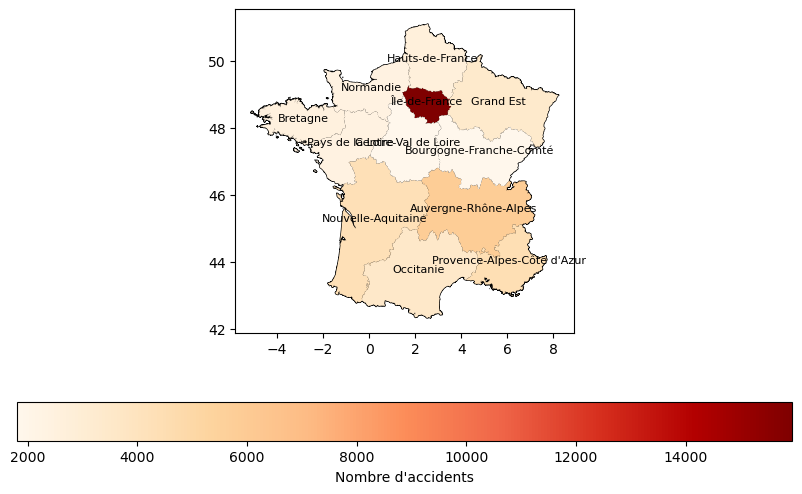

In [106]:
# Compter le nombre d'accidents par région
accidents_par_region = points_acc.groupby('INSEE_REG').size().reset_index(name='Nombre d\'accidents')

# Charger les données géographiques des régions françaises


# Joindre les données des accidents aux données géographiques des régions
regions_accidents = carte_reg.merge(accidents_par_region, on='INSEE_REG')

# Tracer la carte avec les couleurs des régions dégradées en fonction du nombre d'accidents
ax = carte_reg.plot(figsize=(10, 6), color='white', edgecolor='black')
regions_accidents.plot(column='Nombre d\'accidents', ax=ax, legend=True,
                       legend_kwds={'label': "Nombre d'accidents",
                                    'orientation': "horizontal"},
                       cmap='OrRd')

#Ajout des étiquettes des régions
regions_accidents['centroid'] = regions_accidents.geometry.centroid
for x, y, label in zip(regions_accidents.centroid.x, regions_accidents.centroid.y, regions_accidents['LIBELLE_REGION']): plt.text(x, y, label, fontsize=8, ha='center', color='black')

# Afficher la carte
plt.show()


On remarque que l'île-de-France a un nombre d'accidents particulièrement élevé par rapport aux autres régions. Il serait intéressant de faire une analyse approfondie de cette région 

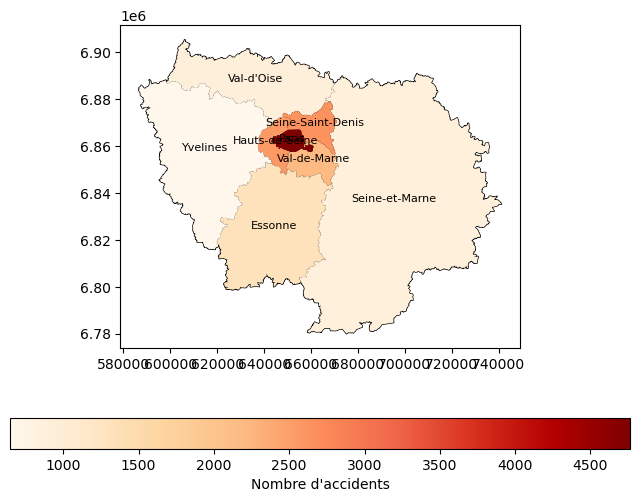

In [ ]:
#Filtres pour Île-de-France
df_caract_IDF = df_caract_FM.loc[df_caract_FM["INSEE_REG"] == 11]
carte_dep_IDF = carte_dep.loc[
    carte_dep['INSEE_DEP'].isin([75, 77, 78, 91, 92, 93, 94, 95])].to_crs(2154)


# Compter le nombre d'accidents par département
accidents_par_dep = points_acc.groupby('INSEE_DEP').size().reset_index(name='Nombre d\'accidents')

# Joindre les données des accidents aux données géographiques des départements
dep_accidents = carte_dep_IDF.merge(accidents_par_dep, on='INSEE_DEP')

# Tracer la carte avec les couleurs des régions dégradées en fonction du nombre d'accidents
ax = carte_dep_IDF.plot(figsize=(8, 6), color='white', edgecolor='black')
dep_accidents.plot(column='Nombre d\'accidents', ax=ax, legend=True,
                       legend_kwds={'label': "Nombre d'accidents",
                                    'orientation': "horizontal"},
                       cmap='OrRd')

#Ajout des étiquettes des régions
dep_accidents['centroid'] = dep_accidents.geometry.centroid
for x, y, label in zip(dep_accidents.centroid.x, dep_accidents.centroid.y, dep_accidents['LIBELLE_DEPARTEMENT']): plt.text(x, y, label, fontsize=8, ha='center', color='black')

# Afficher la carte
plt.show()

Le département le plus touché par les accidents est Paris

# II - Premières analyses

On commence par analyser l'impact de différents paramètres sur la gravité.



In [39]:
df["(Num_Acc, id_usager)"] = list(zip(df["Num_Acc"], df["id_usager"]))
df = df[~df[["(Num_Acc, id_usager)"]].duplicated()]  #on supprime les doublons de (Num_Acc, id_usager)
                                                    # ces doublons existent par exemple lorsqu'un accident
                                                    # se produit à une intersection entre plusieurs voies
df.head(10)

df_grav = df.groupby("gravite").agg({"(Num_Acc, id_usager)": "nunique"})  #on compte toutes les victimes
                                                                        #en fonction de la gravité de leurs 
                                                                        #blessures
df_grav

,"(Num_Acc, id_usager)"
gravite,
-1,118
1,52947
2,3302
3,18981
4,49320


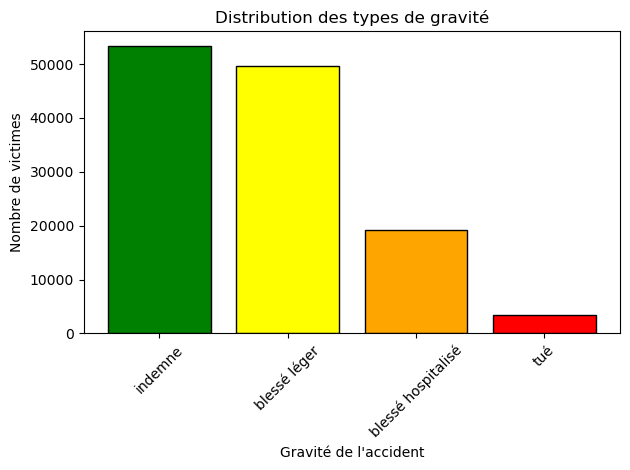

In [40]:
hist = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [53399, 49603, 19271, 3398] }

plt.bar(hist["grav"], hist["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution des types de gravité")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Nombre de victimes")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

On peut également regarder l'impact de la vitesse maximale autorisée sur la gravité de l'accident. Pour chaque vitesse maximale autorisée, on s'intéresse à la distribution de la gravité des accidents.

In [41]:
df_vma_30 = df.loc[df["vma"] <= 30]
df_vma_30.head()
df_vma_50 = df.loc[(df["vma"] > 30) & (df["vma"] <= 50)]
df_vma_50.head()
df_vma_90 = df.loc[(df["vma"] > 50) & (df["vma"] <= 90)]
df_vma_90.head()
df_vma_130 = df.loc[(df["vma"] > 90) & (df["vma"] <= 130)]
df_vma_130.head()

,Num_Acc,id_usager,id_vehicule,num_veh,cat_usager,gravite,motif,equip_secu_1,equip_secu_2,equip_secu_3,cat_vehicule,moteur_vehicule,catr,voie,surf,vma,jour,mois,lum,dep,com,agg,atm,lat,long,dep_name,region_name,"(Num_Acc, id_usager)"
139,202300000046,203851069,155680478,B01,1,3,1,1,-1,-1,7,1,1,35,2,130,7,5,3,67,67205,1,2,"48,68097900","7,80884700",Bas-Rhin,Grand Est,"(202300000046, 203851069)"
140,202300000046,203851070,155680479,A01,1,3,1,1,-1,-1,7,1,1,35,2,130,7,5,3,67,67205,1,2,"48,68097900","7,80884700",Bas-Rhin,Grand Est,"(202300000046, 203851070)"
143,202300000048,203851065,155680474,B01,1,4,1,1,-1,-1,7,1,1,64,1,130,5,5,3,64,64021,1,1,"43,30865800","-0,24835900",Pyrénées-Atlantiques,Nouvelle-Aquitaine,"(202300000048, 203851065)"
144,202300000048,203851066,155680475,A01,1,3,4,1,-1,-1,10,1,1,64,1,130,5,5,3,64,64021,1,1,"43,30865800","-0,24835900",Pyrénées-Atlantiques,Nouvelle-Aquitaine,"(202300000048, 203851066)"
148,202300000050,203851060,155680469,B01,1,1,5,2,-1,-1,33,1,1,1,1,130,8,5,1,62,62761,1,1,"50,23268500","2,85528700",Pas-de-Calais,Hauts-de-France,"(202300000050, 203851060)"


In [42]:
df_grav_30 = df_vma_30.groupby("gravite").agg({"(Num_Acc, id_usager)": "nunique"})
df_grav_30["pourcentage"] = 100 * df_grav_30["(Num_Acc, id_usager)"] / df_grav_30["(Num_Acc, id_usager)"].sum()
prop_30 = df_grav_30["pourcentage"].tolist()

df_grav_50 = df_vma_50.groupby("gravite").agg({"(Num_Acc, id_usager)": "nunique"})
df_grav_50["pourcentage"] = 100 * df_grav_50["(Num_Acc, id_usager)"] / df_grav_50["(Num_Acc, id_usager)"].sum()
prop_50 = df_grav_50["pourcentage"].tolist()

df_grav_90 = df_vma_90.groupby("gravite").agg({"(Num_Acc, id_usager)": "nunique"})
df_grav_90["pourcentage"] = 100 * df_grav_90["(Num_Acc, id_usager)"] / df_grav_90["(Num_Acc, id_usager)"].sum()
prop_90 = df_grav_90["pourcentage"].tolist()

df_grav_130 = df_vma_130.groupby("gravite").agg({"(Num_Acc, id_usager)": "nunique"})
df_grav_130["pourcentage"] = 100 * df_grav_130["(Num_Acc, id_usager)"] / df_grav_130["(Num_Acc, id_usager)"].sum()
prop_130 = df_grav_130["pourcentage"].tolist()

print(df_grav_30, "\n", df_grav_50, "\n", df_grav_90, "\n", df_grav_130)
print(prop_130)

         (Num_Acc, id_usager)  pourcentage
gravite                                   
-1                         38     0.163118
 1                      10514    45.132212
 2                        342     1.468063
 3                       2435    10.452438
 4                       9967    42.784169 
          (Num_Acc, id_usager)  pourcentage
gravite                                   
-1                         53     0.097162
 1                      24119    44.216103
 2                        888     1.627924
 3                       7008    12.847400
 4                      22480    41.211410 
          (Num_Acc, id_usager)  pourcentage
gravite                                   
-1                         25     0.065796
 1                      14207    37.390778
 2                       1803     4.745236
 3                       8412    22.139173
 4                      13549    35.659017 
          (Num_Acc, id_usager)  pourcentage
gravite                                   
-1   

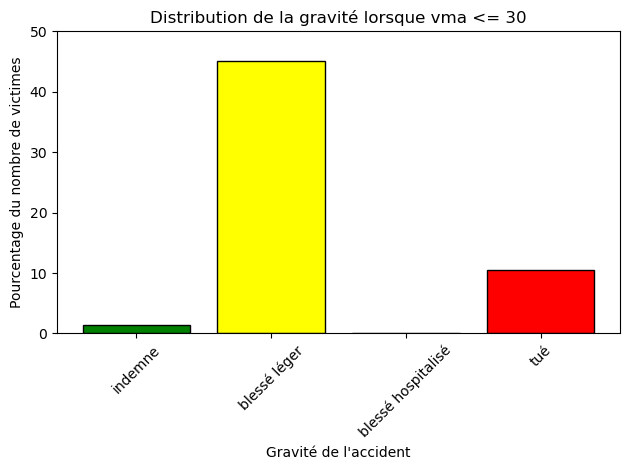

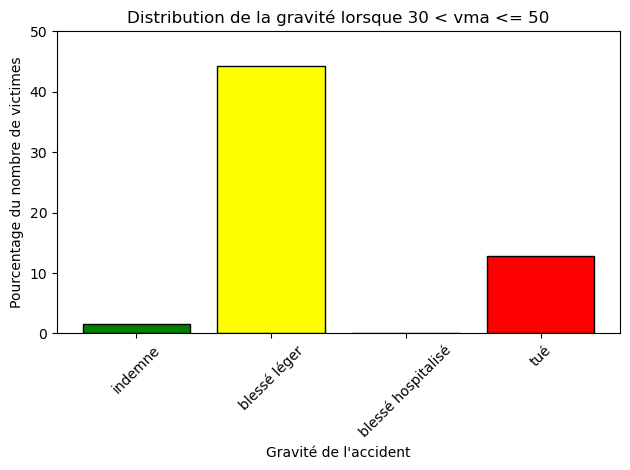

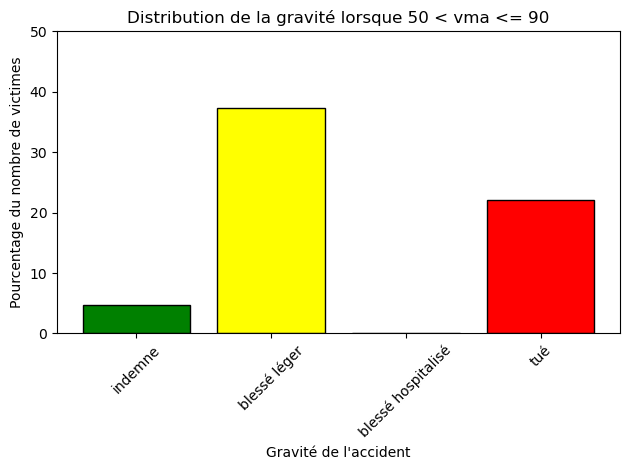

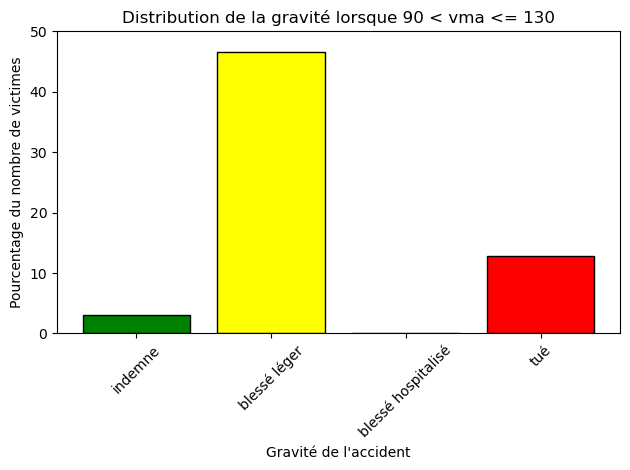

In [43]:
hist_30 = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [prop_30[2], prop_30[1], prop_30[0], prop_30[3]] }

plt.bar(hist_30["grav"], hist_30["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution de la gravité lorsque vma <= 30")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Pourcentage du nombre de victimes")
plt.ylim(top = 50)
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

hist_50 = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [prop_50[2], prop_50[1], prop_50[0], prop_50[3]] }

plt.bar(hist_50["grav"], hist_50["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution de la gravité lorsque 30 < vma <= 50")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Pourcentage du nombre de victimes")
plt.ylim(top = 50)
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

hist_90 = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [prop_90[2], prop_90[1], prop_90[0], prop_90[3]] }

plt.bar(hist_90["grav"], hist_90["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution de la gravité lorsque 50 < vma <= 90")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Pourcentage du nombre de victimes")
plt.ylim(top = 50)
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

hist_130 = { "grav": ["indemne", "blessé léger", "blessé hospitalisé", "tué"],
    "nb": [prop_130[2], prop_130[1], prop_130[0], prop_130[3]] }

plt.bar(hist_130["grav"], hist_130["nb"], color=['green', 'yellow', 'orange', 'red'], edgecolor='black')
plt.title("Distribution de la gravité lorsque 90 < vma <= 130")
plt.xlabel("Gravité de l'accident")
plt.ylabel("Pourcentage du nombre de victimes")
plt.ylim(top = 50)
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

Text(0.5, 1.0, "Nombre d'accidents en 2023 en fonction de la météo")

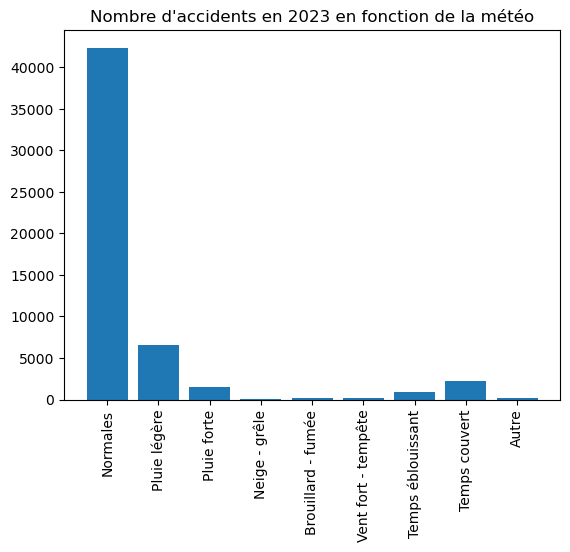

In [44]:
df_atm = df.groupby("atm").agg({"Num_Acc": "nunique"})
Num_Acc = df_atm["Num_Acc"].tolist()
Num_Acc.pop(0)

hist = { "atm" : ["Normales", "Pluie légère", "Pluie forte", "Neige - grêle", "Brouillard - fumée",
                  "Vent fort - tempête", "Temps éblouissant", "Temps couvert", "Autre"],
        "Num_Acc" : Num_Acc}
plt.bar(hist["atm"], hist["Num_Acc"])
plt.xticks(rotation = 90)
plt.title("Nombre d'accidents en 2023 en fonction de la météo")

Le problème est qu'il faudrait ramener ces données au nombre de jours de pluie, neige, etc par an, sur une certaine région particulière, pour pouvoir vraiment juger de l'impact de la météo sur les accidents.
On va donc utiliser les données météorologiques sur l'île-de-France en 2023. 

On considère que le temps est éblouissant si GLOT > 5000 J/cm2 et couvert si GLOT < 1000 J/cm2, que la pluie est forte si RR > 8 mm, légère si 0.1 mm < RR < 8 mm, et que le vent est fort si FFM > 10 m/s. Si GLOT est compris dans [1000, 5000], que RR < 0.1, que FFM < 10 m/s et que les autres valeurs valent 0, ou que des données sont manquantes, on considère que les conditions atmosphériques sont normales.

In [45]:
meteo_75 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_75["Neige - grêle"] = df_meteo_75.loc[(df_meteo_75['NEIG'] == 1) | 
                                                    (df_meteo_75['SOLNEIGE'] == 1) | 
                                                    (df_meteo_75['GRELE'] == 1)].shape[0]
meteo_75["Brouillard - fumée"] = df_meteo_75.loc[(df_meteo_75['BROU'] == 1) |
                                                        (df_meteo_75['FUMEE'] == 1) |
                                                        (df_meteo_75['BRUME'] == 1)].shape[0]
meteo_75["Vent fort - tempête"] = df_meteo_75.loc[df_meteo_75['FFM'] >= 10].shape[0]
meteo_75["Pluie forte"] = df_meteo_75.loc[df_meteo_75['RR'] >= 8].shape[0]
meteo_75["Pluie légère"] = df_meteo_75.loc[(df_meteo_75['RR'] >= 0.1) & (df_meteo_75['RR'] < 8)].shape[0]
meteo_75["Temps éblouissant"] = df_meteo_75.loc[df_meteo_75['GLOT'] > 2500].shape[0]
meteo_75["Temps couvert"] = df_meteo_75.loc[(df_meteo_75['GLOT'] < 400) & (df_meteo_75['GLOT'] != -1)].shape[0]
meteo_75["Normales"] = df_meteo_75.loc[(df_meteo_75['NEIG'] != 1) & (df_meteo_75['SOLNEIGE'] != 1) &
                                        (df_meteo_75['GRELE'] != 1) & (df_meteo_75['BROU'] != 1) &
                                        (df_meteo_75['FUMEE'] != 1) & (df_meteo_75['BRUME'] != 1) &
                                        (df_meteo_75['FFM'] < 10) & (df_meteo_75['RR'] < 0.1) &
                                        (((df_meteo_75['GLOT'] >= 400) & (df_meteo_75['GLOT'] <= 2500)) |
                                        (df_meteo_75['GLOT'] == -1))].shape[0]


meteo_77 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_77["Neige - grêle"] = df_meteo_77.loc[(df_meteo_77['NEIG'] == 1) | 
                                                    (df_meteo_77['SOLNEIGE'] == 1) | 
                                                    (df_meteo_77['GRELE'] == 1)].shape[0]
meteo_77["Brouillard - fumée"] = df_meteo_77.loc[(df_meteo_77['BROU'] == 1) |
                                                        (df_meteo_77['FUMEE'] == 1) |
                                                        (df_meteo_77['BRUME'] == 1)].shape[0]
meteo_77["Vent fort - tempête"] = df_meteo_77.loc[df_meteo_77['FFM'] >= 10].shape[0]
meteo_77["Pluie forte"] = df_meteo_77.loc[df_meteo_77['RR'] >= 8].shape[0]
meteo_77["Pluie légère"] = df_meteo_77.loc[(df_meteo_77['RR'] >= 0.1) & (df_meteo_77['RR'] < 8)].shape[0]
meteo_77["Temps éblouissant"] = df_meteo_77.loc[df_meteo_77['GLOT'] > 2500].shape[0]
meteo_77["Temps couvert"] = df_meteo_77.loc[(df_meteo_77['GLOT'] < 400) & (df_meteo_77['GLOT'] != -1)].shape[0]
meteo_77["Normales"] = df_meteo_77.loc[(df_meteo_77['NEIG'] != 1) & (df_meteo_77['SOLNEIGE'] != 1) &
                                        (df_meteo_77['GRELE'] != 1) & (df_meteo_77['BROU'] != 1) &
                                        (df_meteo_77['FUMEE'] != 1) & (df_meteo_77['BRUME'] != 1) &
                                        (df_meteo_77['FFM'] < 10) & (df_meteo_77['RR'] < 0.1) &
                                        (((df_meteo_77['GLOT'] >= 400) & (df_meteo_77['GLOT'] <= 2500)) |
                                        (df_meteo_77['GLOT'] == -1))].shape[0]


meteo_78 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_78["Neige - grêle"] = df_meteo_78.loc[(df_meteo_78['NEIG'] == 1) | 
                                                    (df_meteo_78['SOLNEIGE'] == 1) | 
                                                    (df_meteo_78['GRELE'] == 1)].shape[0]
meteo_78["Brouillard - fumée"] = df_meteo_78.loc[(df_meteo_78['BROU'] == 1) |
                                                        (df_meteo_78['FUMEE'] == 1) |
                                                        (df_meteo_78['BRUME'] == 1)].shape[0]
meteo_78["Vent fort - tempête"] = df_meteo_78.loc[df_meteo_78['FFM'] >= 10].shape[0]
meteo_78["Pluie forte"] = df_meteo_78.loc[df_meteo_78['RR'] >= 8].shape[0]
meteo_78["Pluie légère"] = df_meteo_78.loc[(df_meteo_78['RR'] >= 0.1) & (df_meteo_78['RR'] < 8)].shape[0]
meteo_78["Temps éblouissant"] = df_meteo_78.loc[df_meteo_78['GLOT'] > 2500].shape[0]
meteo_78["Temps couvert"] = df_meteo_78.loc[(df_meteo_78['GLOT'] < 400) & (df_meteo_78['GLOT'] != -1)].shape[0]
meteo_78["Normales"] = df_meteo_78.loc[(df_meteo_78['NEIG'] != 1) & (df_meteo_78['SOLNEIGE'] != 1) &
                                        (df_meteo_78['GRELE'] != 1) & (df_meteo_78['BROU'] != 1) &
                                        (df_meteo_78['FUMEE'] != 1) & (df_meteo_78['BRUME'] != 1) &
                                        (df_meteo_78['FFM'] < 10) & (df_meteo_78['RR'] < 0.1) &
                                        (((df_meteo_78['GLOT'] >= 400) & (df_meteo_78['GLOT'] <= 2500)) |
                                        (df_meteo_78['GLOT'] == -1))].shape[0]

meteo_91 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_91["Neige - grêle"] = df_meteo_91.loc[(df_meteo_91['NEIG'] == 1) | 
                                                    (df_meteo_91['SOLNEIGE'] == 1) | 
                                                    (df_meteo_91['GRELE'] == 1)].shape[0]
meteo_91["Brouillard - fumée"] = df_meteo_91.loc[(df_meteo_91['BROU'] == 1) |
                                                        (df_meteo_91['FUMEE'] == 1) |
                                                        (df_meteo_91['BRUME'] == 1)].shape[0]
meteo_91["Vent fort - tempête"] = df_meteo_91.loc[df_meteo_91['FFM'] >= 10].shape[0]
meteo_91["Pluie forte"] = df_meteo_91.loc[df_meteo_91['RR'] >= 8].shape[0]
meteo_91["Pluie légère"] = df_meteo_91.loc[(df_meteo_91['RR'] >= 0.1) & (df_meteo_91['RR'] < 8)].shape[0]
meteo_91["Temps éblouissant"] = df_meteo_91.loc[df_meteo_91['GLOT'] > 2500].shape[0]
meteo_91["Temps couvert"] = df_meteo_91.loc[(df_meteo_91['GLOT'] < 400) & (df_meteo_91['GLOT'] != -1)].shape[0]
meteo_91["Normales"] = df_meteo_91.loc[(df_meteo_91['NEIG'] != 1) & (df_meteo_91['SOLNEIGE'] != 1) &
                                        (df_meteo_91['GRELE'] != 1) & (df_meteo_91['BROU'] != 1) &
                                        (df_meteo_91['FUMEE'] != 1) & (df_meteo_91['BRUME'] != 1) &
                                        (df_meteo_91['FFM'] < 10) & (df_meteo_91['RR'] < 0.1) &
                                        (((df_meteo_91['GLOT'] >= 400) & (df_meteo_91['GLOT'] <= 2500)) |
                                        (df_meteo_91['GLOT'] == -1))].shape[0]

meteo_92 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_92["Neige - grêle"] = df_meteo_92.loc[(df_meteo_92['NEIG'] == 1) | 
                                                    (df_meteo_92['SOLNEIGE'] == 1) | 
                                                    (df_meteo_92['GRELE'] == 1)].shape[0]
meteo_92["Brouillard - fumée"] = df_meteo_92.loc[(df_meteo_92['BROU'] == 1) |
                                                        (df_meteo_92['FUMEE'] == 1) |
                                                        (df_meteo_92['BRUME'] == 1)].shape[0]
meteo_92["Vent fort - tempête"] = df_meteo_92.loc[df_meteo_92['FFM'] >= 10].shape[0]
meteo_92["Pluie forte"] = df_meteo_92.loc[df_meteo_92['RR'] >= 8].shape[0]
meteo_92["Pluie légère"] = df_meteo_92.loc[(df_meteo_92['RR'] >= 0.1) & (df_meteo_92['RR'] < 8)].shape[0]
meteo_92["Temps éblouissant"] = df_meteo_92.loc[df_meteo_92['GLOT'] > 2500].shape[0]
meteo_92["Temps couvert"] = df_meteo_92.loc[(df_meteo_92['GLOT'] < 400) & (df_meteo_92['GLOT'] != -1)].shape[0]
meteo_92["Normales"] = df_meteo_92.loc[(df_meteo_92['NEIG'] != 1) & (df_meteo_92['SOLNEIGE'] != 1) &
                                        (df_meteo_92['GRELE'] != 1) & (df_meteo_92['BROU'] != 1) &
                                        (df_meteo_92['FUMEE'] != 1) & (df_meteo_92['BRUME'] != 1) &
                                        (df_meteo_92['FFM'] < 10) & (df_meteo_92['RR'] < 0.1) &
                                        (((df_meteo_92['GLOT'] >= 400) & (df_meteo_92['GLOT'] <= 2500)) |
                                        (df_meteo_92['GLOT'] == -1))].shape[0]

meteo_93 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_93["Neige - grêle"] = df_meteo_93.loc[(df_meteo_93['NEIG'] == 1) | 
                                                    (df_meteo_93['SOLNEIGE'] == 1) | 
                                                    (df_meteo_93['GRELE'] == 1)].shape[0]
meteo_93["Brouillard - fumée"] = df_meteo_93.loc[(df_meteo_93['BROU'] == 1) |
                                                        (df_meteo_93['FUMEE'] == 1) |
                                                        (df_meteo_93['BRUME'] == 1)].shape[0]
meteo_93["Vent fort - tempête"] = df_meteo_93.loc[df_meteo_93['FFM'] >= 10].shape[0]
meteo_93["Pluie forte"] = df_meteo_93.loc[df_meteo_93['RR'] >= 8].shape[0]
meteo_93["Pluie légère"] = df_meteo_93.loc[(df_meteo_93['RR'] >= 0.1) & (df_meteo_93['RR'] < 8)].shape[0]
meteo_93["Temps éblouissant"] = df_meteo_93.loc[df_meteo_93['GLOT'] > 2500].shape[0]
meteo_93["Temps couvert"] = df_meteo_93.loc[(df_meteo_93['GLOT'] < 400) & (df_meteo_93['GLOT'] != -1)].shape[0]
meteo_93["Normales"] = df_meteo_93.loc[(df_meteo_93['NEIG'] != 1) & (df_meteo_93['SOLNEIGE'] != 1) &
                                        (df_meteo_93['GRELE'] != 1) & (df_meteo_93['BROU'] != 1) &
                                        (df_meteo_93['FUMEE'] != 1) & (df_meteo_93['BRUME'] != 1) &
                                        (df_meteo_93['FFM'] < 10) & (df_meteo_93['RR'] < 0.1) &
                                        (((df_meteo_93['GLOT'] >= 400) & (df_meteo_93['GLOT'] <= 2500)) |
                                        (df_meteo_93['GLOT'] == -1))].shape[0]

meteo_94 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_94["Neige - grêle"] = df_meteo_94.loc[(df_meteo_94['NEIG'] == 1) | 
                                                    (df_meteo_94['SOLNEIGE'] == 1) | 
                                                    (df_meteo_94['GRELE'] == 1)].shape[0]
meteo_94["Brouillard - fumée"] = df_meteo_94.loc[(df_meteo_94['BROU'] == 1) |
                                                        (df_meteo_94['FUMEE'] == 1) |
                                                        (df_meteo_94['BRUME'] == 1)].shape[0]
meteo_94["Vent fort - tempête"] = df_meteo_94.loc[df_meteo_94['FFM'] >= 10].shape[0]
meteo_94["Pluie forte"] = df_meteo_94.loc[df_meteo_94['RR'] >= 8].shape[0]
meteo_94["Pluie légère"] = df_meteo_94.loc[(df_meteo_94['RR'] >= 0.1) & (df_meteo_94['RR'] < 8)].shape[0]
meteo_94["Temps éblouissant"] = df_meteo_94.loc[df_meteo_94['GLOT'] > 2500].shape[0]
meteo_94["Temps couvert"] = df_meteo_94.loc[(df_meteo_94['GLOT'] < 400) & (df_meteo_94['GLOT'] != -1)].shape[0]
meteo_94["Normales"] = df_meteo_94.loc[(df_meteo_94['NEIG'] != 1) & (df_meteo_94['SOLNEIGE'] != 1) &
                                        (df_meteo_94['GRELE'] != 1) & (df_meteo_94['BROU'] != 1) &
                                        (df_meteo_94['FUMEE'] != 1) & (df_meteo_94['BRUME'] != 1) &
                                        (df_meteo_94['FFM'] < 10) & (df_meteo_94['RR'] < 0.1) &
                                        (((df_meteo_94['GLOT'] >= 400) & (df_meteo_94['GLOT'] <= 2500)) |
                                        (df_meteo_94['GLOT'] == -1))].shape[0]

meteo_95 = { "Normales" : 0, "Pluie légère" : 0, "Pluie forte" : 0, "Neige - grêle" : 0, "Brouillard - fumée" : 0,
"Vent fort - tempête" : 0, "Temps éblouissant" : 0, "Temps couvert" : 0}

meteo_95["Neige - grêle"] = df_meteo_95.loc[(df_meteo_95['NEIG'] == 1) | 
                                                    (df_meteo_95['SOLNEIGE'] == 1) | 
                                                    (df_meteo_95['GRELE'] == 1)].shape[0]
meteo_95["Brouillard - fumée"] = df_meteo_95.loc[(df_meteo_95['BROU'] == 1) |
                                                        (df_meteo_95['FUMEE'] == 1) |
                                                        (df_meteo_95['BRUME'] == 1)].shape[0]
meteo_95["Vent fort - tempête"] = df_meteo_95.loc[df_meteo_95['FFM'] >= 10].shape[0]
meteo_95["Pluie forte"] = df_meteo_95.loc[df_meteo_95['RR'] >= 8].shape[0]
meteo_95["Pluie légère"] = df_meteo_95.loc[(df_meteo_95['RR'] >= 0.1) & (df_meteo_95['RR'] < 8)].shape[0]
meteo_95["Temps éblouissant"] = df_meteo_95.loc[df_meteo_95['GLOT'] > 2500].shape[0]
meteo_95["Temps couvert"] = df_meteo_95.loc[(df_meteo_95['GLOT'] < 400) & (df_meteo_95['GLOT'] != -1)].shape[0]
meteo_95["Normales"] = df_meteo_95.loc[(df_meteo_95['NEIG'] != 1) & (df_meteo_95['SOLNEIGE'] != 1) &
                                        (df_meteo_95['GRELE'] != 1) & (df_meteo_95['BROU'] != 1) &
                                        (df_meteo_95['FUMEE'] != 1) & (df_meteo_95['BRUME'] != 1) &
                                        (df_meteo_95['FFM'] < 10) & (df_meteo_95['RR'] < 0.1) &
                                        (((df_meteo_95['GLOT'] >= 400) & (df_meteo_95['GLOT'] <= 2500)) |
                                        (df_meteo_95['GLOT'] == -1))].shape[0]

meteo = { k : (meteo_75[k] + meteo_77[k] + meteo_78[k] + meteo_91[k] + meteo_92[k] + meteo_93[k] + meteo_94[k] + meteo_95[k])/8 for k in meteo_75}
print(meteo)
tot = 0
for d in meteo :
    tot += meteo[d]
print(tot)

    

{'Normales': 61.5, 'Pluie légère': 170.0, 'Pluie forte': 29.0, 'Neige - grêle': 1.125, 'Brouillard - fumée': 22.25, 'Vent fort - tempête': 0.25, 'Temps éblouissant': 22.25, 'Temps couvert': 53.25}
359.625


Le problème est qu'on obtient plus de 365 jours car certaines conditions météorologiques peuvent se cumuler ( ex : neige et brouillard, ou pluie forte et vent fort). Or dans la base d'accidents, les conditions météo ne se cumulent pas. Par ailleurs, on trouve qu'il n'y a eu aucun jour avec un temps éblouissant.
On retrace l'histogramme du nombre d'accidents en fonction de la météo, mais par jour.

Text(0.5, 1.0, "Nombre d'accidents en 2023 en fonction de la météo, par jour, en île-de-france")

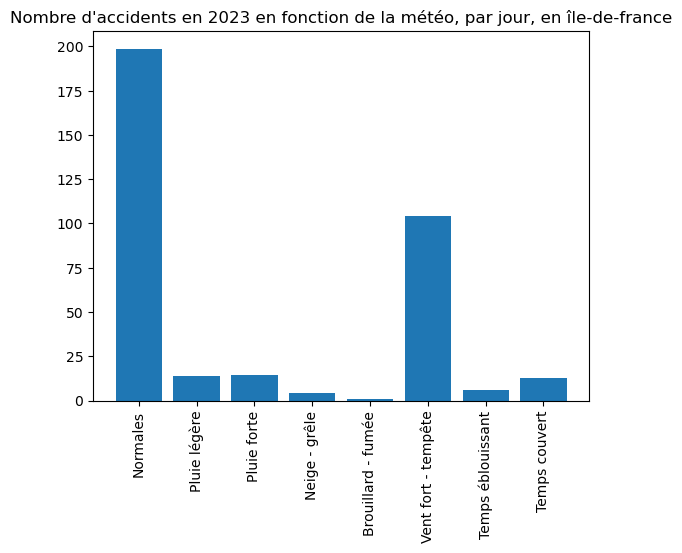

In [46]:
df_idf = df.loc[(df['dep'] ==75) | (df['dep'] ==77) | (df['dep'] ==78) | (df['dep'] ==91) |
                (df['dep'] ==92) | (df['dep'] ==93) | (df['dep'] ==94) | (df['dep'] ==95)]
df_atm = df_idf.groupby("atm").agg({"Num_Acc": "nunique"})
Num_Acc = df_atm["Num_Acc"].tolist()
Num_Acc.pop()
nb_jours = [meteo[k] for k in meteo]
Num_Acc_pjour = [Num_Acc[k]/nb_jours[k] for k in range (len(Num_Acc))]

hist = { "atm" : ["Normales", "Pluie légère", "Pluie forte", "Neige - grêle", "Brouillard - fumée",
                  "Vent fort - tempête", "Temps éblouissant", "Temps couvert"],
        "Num_Acc" : Num_Acc_pjour}
plt.bar(hist["atm"], hist["Num_Acc"])
plt.xticks(rotation = 90)
plt.title("Nombre d'accidents en 2023 en fonction de la météo, par jour, en île-de-france")

# IV. Modélisation

On cherche à prévoir la gravité d'un accident en fonction de ses caractéristiques, c'est-à-dire sa localisation, la vitesse maximale autorisée et les conditions météorologiques.

In [49]:
!pip install tabulate

In [51]:
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

#informations susceptibles susceptibles d'être fournies lorsque les secours seront appelés
Xvars = ["cat_usager", "cat_vehicule", "catr", "voie", "vma", "jour", "mois", "dep", "atm"]
df_model1 = df.loc[:, Xvars + ["gravite"]]
encoder = LabelEncoder()
df_model1["voie"] = encoder.fit_transform(df_model1["voie"])

X_train, X_test, y_train, y_test = train_test_split(
    df_model1[Xvars], df_model1[["gravite"]].values.ravel(), test_size=0.2, random_state=123 )

#Entraînement du modèle et performances
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calcul des métriques pour un problème multiclass
sc_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
sc_f1 = sklearn.metrics.f1_score(y_test, y_pred, average="weighted")
sc_recall = sklearn.metrics.recall_score(y_test, y_pred, average="weighted")
sc_precision = sklearn.metrics.precision_score(y_test, y_pred, average="weighted")

# Affichage des scores
out = pd.DataFrame.from_dict(
    {
        "Accuracy": [sc_accuracy],
        "Recall": [sc_recall],
        "Precision": [sc_precision],
        "F1": [sc_f1],
    },
    orient="index",
    columns=["Score"],
)
print(out.to_markdown())

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.428451 |
| Recall    | 0.428451 |
| Precision | 0.349802 |
| F1        | 0.384305 |


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
